# DATA 620 - Project 1 (Week 5)

## Introduction

In the proposed project, I plan to explore the log return correlation network of the instrument constituents of the current S&P500 equity index. I will use the sector and sub-industry categorical data for each of the stocks comprising the current S&P500 to determine whether these variables influence co-movement in the returns of groups of stocks. In the first section, the data will be acquired and cleaned. In the second section, I will build and explore the unfiltered correlation network, computing both weighted degree and eigenvector centrality, then examining the relationship between these metrics and the categorical variable (sub-industry). In the third section, I will filter the network using Prim's algorithm to produce a minimal spanning tree (MST) representation of the graph, then re-examine some common metrics (including weighted degree). In the last section, I will present conclusions and outline potential practical applications.

### Data Acquisition & Cleaning

To perform the analysis briefly outlined above, we require a list of the current constituents of the S&P500 index, along with corresponding sector, sub-industry, and price data. This data will be acquired from two sources. The S&P500 index constituent data (ticker, name, sector and sub-industry) will be scraped from Wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). Stock prices will be acquired from yahoo using the pandas-datareader API.

### Correlation Network

Prior to any filtering of the return correlation network, it is typically difficult to find clear relationships between stocks using common centrality metrics. I expect that metrics such as weighted degree and eigenvector centrality will provide only limited information about the structure of the network prior to filtering. 

### Minimal Spanning Tree (MST)

After filtering the return correlation network, I expect that we will be able to identify hubs and clusters that - at least partially - align with our sub-industry categorical variable. Additional categorical variables - such as capitalization - may be required to interpret the underlying reason for identified hubs. I also expect to be able to identify both stocks that tend to be central to common movement among particular groups of stocks within the universe under study, and diversifying stocks that appear to be driven predominately by uncommon (specific) factors.

## Appendix

Although we are not required to complete any of the planned work discussed in the section immediately above for this assignment, the following sections of this Appendix provide some of the exploratory work that was done while scoping out the proposed project.

### Data Acquisition & Cleaning

We start by preparing data for use in a correlation network. Part of the data set - which forms the main piece of the instrument master for our universe under study - was scraped from wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). Although the stock prices were acquired from a commercial source (CSI Data), an alternative data source (yahoo) will be used for the project.

We import the required packages:

In [967]:
import pandas
import numpy
import math
import matplotlib.pyplot as plt
import seaborn
from timeit import default_timer as timer
import networkx

# inline matplotlib
%matplotlib inline

We set the data acquisition flag:

In [1035]:


# code to acquire data
readHdf5Flag=True
if (readHdf5Flag == True):
    print('read')
else:
    print('fetch')



read


We load an instrument master which maps each equity instrument to instrument characteristics such as security type, sector, industry group, industry, and sub-industry:

In [1032]:
# set the HDF5 output file directory
instrumentMasterDirectory='C:/Users/Derek/Documents/GitHub/DATA_620/Projects/W5/'
# define the input file name for prices and true range
instrumentMasterFileName='sp500_wiki_yahoo.h5'
# read instrument master from the HDF5 data store
instrumentMaster = pandas.read_hdf(priceDirectory+priceFileName,'instrumentMaster')
# rename columns
instrumentMaster.rename(columns={'Ticker symbol' : 'instrumentTicker',
    'Security' : 'instrumentName','GICS Sector' : 'gicsSectorName',
    'GICS Sub Industry' : 'gicsSubIndustryName'},inplace=True)

In [1034]:
len(instrumentMaster)

505

In [1033]:
instrumentMaster.head()

,instrumentTicker,instrumentName,gicsSectorName,gicsSubIndustryName
0,MMM,3M Company,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
3,ACN,Accenture plc,Information Technology,IT Consulting & Other Services
4,ATVI,Activision Blizzard,Information Technology,Home Entertainment Software


In [1036]:
instrumentMaster.tail()

,instrumentTicker,instrumentName,gicsSectorName,gicsSubIndustryName
500,XYL,Xylem Inc.,Industrials,Industrial Machinery
501,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants
502,ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment
503,ZION,Zions Bancorp,Financials,Regional Banks
504,ZTS,Zoetis,Health Care,Pharmaceuticals


Instrument master data was scraped from Wikipedia. The data represents a the current S&P500 instrument universe.

Find the number of stocks by sector:

In [1038]:
instrumentMaster.groupby(['gicsSectorName'])['gicsSectorName'].count()

gicsSectorName
Consumer Discretionary        83
Consumer Staples              34
Energy                        32
Financials                    68
Health Care                   62
Industrials                   66
Information Technology        70
Materials                     25
Real Estate                   33
Telecommunication Services     4
Utilities                     28
Name: gicsSectorName, dtype: int64

Find the number of stocks by sector and sub-industry: 

In [1039]:
instrumentMaster.groupby(['gicsSectorName','gicsSubIndustryName'])['gicsSubIndustryName'].count()

gicsSectorName              gicsSubIndustryName                         
Consumer Discretionary      Advertising                                      2
                            Apparel Retail                                   5
                            Apparel, Accessories & Luxury Goods             10
                            Auto Parts & Equipment                           2
                            Automobile Manufacturers                         2
                            Automotive Retail                                1
                            Broadcasting                                     1
                            Cable & Satellite                                9
                            Casinos & Gaming                                 2
                            Computer & Electronics Retail                    1
                            Consumer Electronics                             1
                            Department Stores             

We load the price data from the HDF5 file:

In [1040]:
# set the HDF5 output file directory
priceDirectory='C:/Users/Derek/Documents/GitHub/DATA_620/Projects/W5/'
# define the input file name for prices and true range
priceFileName='sp500_wiki_yahoo.h5'
# read the price data from the HDF5 data store
prices = pandas.read_hdf(priceDirectory+priceFileName,'price')
# reindex
prices=prices.set_index(pandas.to_datetime(prices.index))
# define subset
startDate='2006-10-31'
# subset
prices=prices.loc[startDate:]

Extract the ticker names:

In [1041]:
tickers=prices.columns.values

We can see the number of observations available for each ticker using the following operation:

In [1042]:
# find the number of observations available for each ticker
numberOfObservations=numpy.sum(prices.isnull()==False,axis=0)
# print the result
print(numberOfObservations)

A       2748
AAL     2748
AAP     2748
AAPL    2748
ABBV    1196
ABC     2748
ABT     2748
ACN     2748
ADBE    2748
ADI     2748
ADM     2748
ADP     2748
ADS     2748
ADSK    2748
AEE     2748
AEP     2748
AES     2748
AET     2748
AFL     2748
AGN     2748
AIG     2748
AIV     2748
AIZ     2748
AJG     2748
AKAM    2748
ALB     2748
ALGN    2748
ALK     2748
ALL     2748
ALLE     974
        ... 
VRTX    2748
VTR     2748
VZ      2748
WAT     2748
WBA     2748
WDC     2748
WEC     2748
WFC     2748
WHR     2748
WLTW    2748
WM      2748
WMB     2748
WMT     2748
WRK      573
WU      2748
WY      2748
WYN     2748
WYNN    2748
XEC     2748
XEL     2748
XL      2748
XLNX    2748
XOM     2748
XRAY    2748
XRX     2748
XYL     1501
YUM     2748
ZBH     2748
ZION     238
ZTS     1175
Length: 503, dtype: int64


We look at the distribution of the number of observations by ticker:

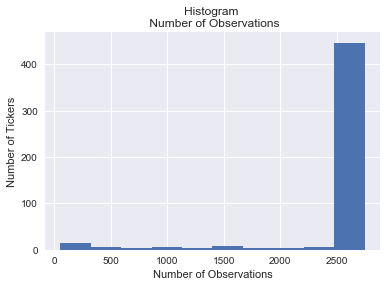

In [1043]:
numberOfObservations.hist()
plt.title('Histogram \n Number of Observations')
plt.xlabel('Number of Observations')
plt.ylabel('Number of Tickers')

Most of the stocks have 2748 daily periods.

In [1044]:
# find the single stocks with full samples
fullSampleIndex=numberOfObservations==2748
# extract the prices for the single stocks with full samples
cleanPrices=prices.loc[:,fullSampleIndex]
# find the instrument master records with full price samples
fullSampleInstrumentIndex=instrumentMaster['instrumentTicker'].isin(cleanPrices.columns.values)
# extract the instrument master records with full price samples
instrumentMaster=instrumentMaster.loc[fullSampleInstrumentIndex]

We compute the log returns:

In [1045]:
# log price by instrument
logPrices=numpy.log(cleanPrices)
# first difference to get returns
logReturns=logPrices.diff(periods=1,axis=0)

Display the daily log returns:

In [872]:
logReturns

,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,YUM,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-01,0.016176,-0.027449,-0.016120,-0.023965,-0.001272,-0.001896,0.002125,-0.012893,-0.004725,-0.050337,...,-0.011625,0.004156,0.000905,-0.011691,-0.022597,-0.005053,-0.014815,-0.001766,0.000504,-0.002921
2006-11-02,-0.020149,-0.021040,0.052019,-0.002277,-0.018412,0.000843,0.010557,-0.002652,-0.002529,-0.026291,...,0.000137,-0.004711,-0.007725,0.001003,-0.010075,0.001828,0.031303,-0.011855,-0.002019,0.006663
2006-11-03,-0.014471,-0.001686,-0.008299,-0.008775,-0.018757,0.003785,-0.007227,0.002387,-0.011782,-0.040927,...,0.010127,0.019530,0.000912,-0.005747,0.012078,0.013395,-0.041412,-0.001791,-0.023002,0.007443
2006-11-06,0.032858,0.054378,0.005540,0.017975,0.008331,-0.003575,0.018267,0.020711,0.019351,-0.000292,...,0.024347,-0.001636,0.000911,0.017993,0.033835,0.010479,0.016255,0.000597,0.017766,0.026560
2006-11-07,-0.011824,0.010727,-0.004429,0.009986,0.001309,0.008182,-0.017965,0.027385,0.018674,-0.020370,...,-0.005196,-0.025423,-0.002736,0.011537,0.024457,-0.005226,0.015043,0.009507,0.005572,-0.000936
2006-11-08,0.001189,-0.021571,0.018964,0.023811,-0.004371,-0.012193,0.010219,0.005037,-0.002470,0.063550,...,0.030132,0.021595,0.009543,-0.003644,0.013126,0.021820,-0.000318,0.004719,-0.003373,-0.007254
2006-11-09,0.012103,-0.012597,0.010562,0.010737,-0.017008,-0.030930,-0.002095,-0.003019,-0.017462,0.000839,...,0.021161,0.006553,0.002259,-0.008744,-0.001492,0.010781,-0.013114,-0.004719,0.002699,-0.013575
2006-11-10,0.007600,0.007942,0.006177,-0.002643,0.005332,0.002832,0.014872,-0.007080,0.010327,-0.008425,...,0.042121,-0.010945,0.003154,0.007901,0.004468,-0.002550,0.001287,-0.000592,0.023151,0.012495


Display the most recent daily log returns:

In [1046]:
logReturns.tail(5)

,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,YUM,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-25,-0.016091,0.013508,0.024287,-0.008861,-0.000864,0.001903,0.001884,-0.026821,-0.012322,0.004370,...,-0.026431,0.030561,0.006098,0.005598,0.001729,0.013176,0.010706,0.003615,-0.026949,-0.000262
2017-09-26,-0.009624,-0.002519,-0.003580,0.017057,0.012517,0.004551,-0.009600,0.005725,0.000358,-0.001148,...,0.024428,-0.009230,0.000210,-0.030399,0.001007,-0.001112,0.006571,0.013740,-0.007465,0.003317
2017-09-27,0.004358,-0.015462,0.017673,0.007092,0.005230,-0.013333,-0.001463,0.007059,0.011965,-0.010858,...,0.004553,0.019848,-0.014143,-0.006298,0.013005,0.006654,0.003688,0.007094,-0.004096,0.012987
2017-09-28,-0.006388,0.013568,0.001710,-0.006179,-0.017624,0.028171,-0.002345,0.002728,0.008443,-0.006993,...,-0.006214,-0.010968,0.006991,0.029055,-0.003413,0.009290,-0.007602,0.004737,0.005457,-0.005088
2017-09-29,0.003433,0.000000,-0.003020,0.005465,0.021498,-0.005234,-0.009212,0.015878,0.006170,-0.005630,...,0.030960,-0.005090,-0.001056,0.008656,0.009077,-0.002558,0.009745,-0.016977,0.001495,0.012288


Plot the daily log price time series for ticker 'A':

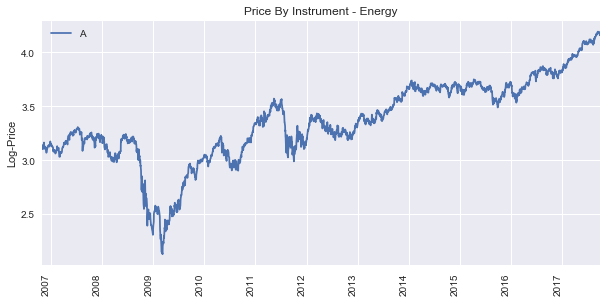

In [943]:
# display the returns
logPrices['A'].plot(legend=True,figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Log-Price")


Plot the daily log return for the ticker 'A':

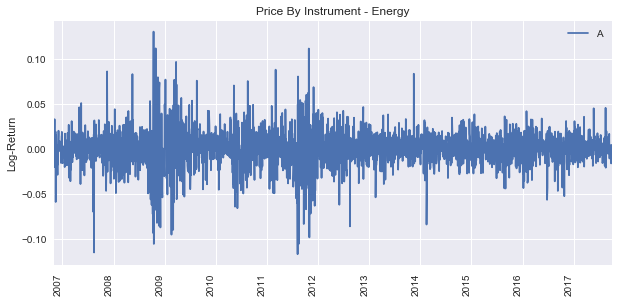

In [942]:
# display the returns
logReturns['A'].plot(legend=True,figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Log-Return")


Standardize the returns (i.e., remove the mean and divide by the standard deviation):

In [637]:
# define standardization function
fStandardize=lambda x : x-numpy.mean(x)/numpy.std(x)
# standardize log returns
stdLogReturns=logReturns.apply(fStandardize,axis=1)

Plot the standardized return for ticker 'A':

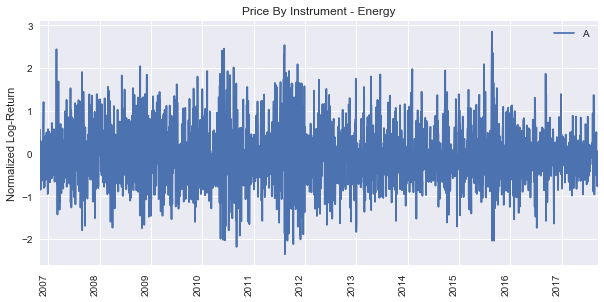

In [941]:
stdLogReturns['A'].plot(legend=True,figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Normalized Log-Return")


Extract standardized returns for approximately the last 2 years:

In [879]:
# compute the correlation matrix using d
recentStdLogReturns=stdLogReturns['2012-09-15':]

Compute the rollong return correlations:

In [969]:
# define the size of the rolling window in days (roughly 2 years)
lookback=500
# compute the rolling correlations
rollingCorrelation=recentStdLogReturns.rolling(window=lookback,
    min_periods=lookback).corr(pairwise=True)

In [968]:
rollingCorrelation.tail()

A       AAL       AAP      AAPL       ABC       ABT  \
2017-09-15 XRAY  0.999675  0.999197  0.999041  0.999509  0.999369  0.999659   
           XRX   0.999378  0.998942  0.998809  0.999292  0.999119  0.999319   
           YUM   0.999468  0.999086  0.998958  0.999447  0.999177  0.999435   
           ZBH   0.999591  0.999138  0.998995  0.999467  0.999249  0.999638   
           ZION  0.999474  0.999188  0.998875  0.999358  0.999164  0.999394   

                      ACN      ADBE       ADI       ADM    ...          XEC  \
2017-09-15 XRAY  0.999667  0.999574  0.999475  0.999445    ...     0.998919   
           XRX   0.999370  0.999271  0.999221  0.999264    ...     0.998895   
           YUM   0.999531  0.999601  0.999338  0.999283    ...     0.998889   
           ZBH   0.999532  0.999542  0.999372  0.999345    ...     0.998991   
           ZION  0.999433  0.999317  0.999364  0.999320    ...     0.999102   

                      XEL        XL      XLNX       XOM      XRAY       XRX  \
2017-09-15 XRAY  0.999626  0.999543  0.999521  0.999588  1.000000  0.999330   
           XRX   0.999296  0.999316  0.999214  0.999350  0.999330  1.000000   
           YUM   0.999512  0.999405  0.999415  0.999457  0.999405  0.999126   
           ZBH   0.999509  0.999436  0.999366  0.999543  0.999586  0.999233   
           ZION  0.999203  0.999478  0.999324  0.999478  0.999371  0.999237   

                      YUM       ZBH      ZION  
2017-09-15 XRAY  0.999405  0.999586  0.999371  
           XRX   0.999126  0.999233  0.999237  
           YUM   1.000000  0.999369  0.999267  
           ZBH   0.999369  1.000000  0.999321  
           ZION  0.999267  0.999321  1.000000  

[5 rows x 457 columns]

It is important to note that computing 500-day rolling correlations between 457 instruments produces an extremely noisey result. These results are of little use in practice without employing methods to improve the quality of the estimates (using bootstrapping for example). Employing such methods is beyond the scope of this assignment.

Plot the pairwise 500-day rolling correlation between tickers 'AAPL' and 'AMZN':

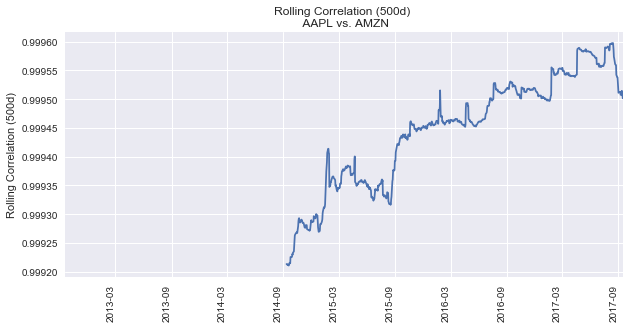

In [970]:
# define title
titleName='Rolling Correlation (500d) \n AAPL vs. AMZN'
# plot rolling correlation
rollingCorrelation.unstack(1)[('AAPL', 'AMZN')].plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Rolling Correlation (500d)")

We can normalize for differing cross-sectional variability and create a price index that places emphasis on differences in price trends (drift) as follows:

In [891]:
# define standardization function where mean is retained
fStd=lambda x : x/numpy.std(x)
# standardize log returns
stdLogReturnsWithMean=logReturns.apply(fStd,axis=1)

Plot the variability-normalized price indices for the enitre universe under study:

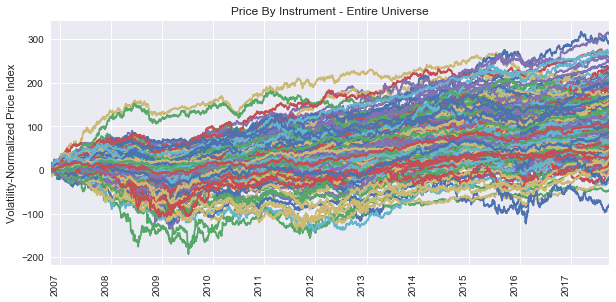

In [946]:
# define title
titleName='Price By Instrument - Entire Universe'
# create variability-normalized price index
standardizedLogPricesWithMean=stdLogReturnsWithMean.cumsum(axis=0)
# plot price index
standardizedLogPricesWithMean.plot(legend=False,figsize=(10,5),
    rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

### Energy 

Now we focus on a smaller portion of our instrument universe, namely the 'Energy' sector.

In [1063]:
gicsSectorName='Energy'
# create energy stock index
energyIndex=instrumentMaster['gicsSectorName']==gicsSectorName
# extract energy stock tickers
energyTickers=instrumentMaster['instrumentTicker'].loc[energyIndex].values
# extract instrument names
energy_instrumentNames=instrumentMaster['instrumentName'].loc[energyIndex].values
# extract GICs sub-industry names
energy_gicsSubIndustryName=instrumentMaster['gicsSubIndustryName'].loc[energyIndex].values

In [1064]:
energy_gicsSubIndustryName

array(['Oil & Gas Exploration & Production',
       'Oil & Gas Refining & Marketing',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production', 'Integrated Oil & Gas',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production', 'Integrated Oil & Gas',
       'Oil & Gas Equipment & Services', 'Oil & Gas Drilling',
       'Integrated Oil & Gas', 'Oil & Gas Exploration & Production',
       'Oil & Gas Equipment & Services',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Storage & Transportation',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Exploration & Production',
       'Oil & Gas Equipment & Services', 'Oil & Gas Equipment &

Create a dictionary to lookup sub-industry by ticker:

In [1065]:
# create dictionary
ticker2SubIndustry=dict()
# iterate over each ticker
for i in range(0,len(energyTickers)):
    # extract ticker
    ticker=energyTickers[i]
    # extract sub-industry
    subIndustry=energy_gicsSubIndustryName[i]
    # add sub-industry by ticker
    ticker2SubIndustry[ticker]=subIndustry

We extract a small subset of the S&P500 instrument master for the energy stocks:

In [1051]:
instrumentMaster.loc[energyIndex].groupby(['instrumentName','instrumentTicker','gicsSubIndustryName'])['gicsSectorName'].count()

instrumentName               instrumentTicker  gicsSubIndustryName               
Anadarko Petroleum Corp      APC               Oil & Gas Exploration & Production    1
Andeavor                     ANDV              Oil & Gas Refining & Marketing        1
Apache Corporation           APA               Oil & Gas Exploration & Production    1
Cabot Oil & Gas              COG               Oil & Gas Exploration & Production    1
Chesapeake Energy            CHK               Oil & Gas Exploration & Production    1
Chevron Corp.                CVX               Integrated Oil & Gas                  1
Cimarex Energy               XEC               Oil & Gas Exploration & Production    1
ConocoPhillips               COP               Oil & Gas Exploration & Production    1
Devon Energy Corp.           DVN               Oil & Gas Exploration & Production    1
EOG Resources                EOG               Oil & Gas Exploration & Production    1
EQT Corporation              EQT               O

Given that the energy sector is composed of 6 sub-industries (see table  immediately below), we might expect to be able to detect clusters using the co-movement of stock prices within the sector.

In [1066]:
instrumentMaster.loc[energyIndex].groupby(['gicsSectorName',
    'gicsSubIndustryName'])['gicsSubIndustryName'].count()

gicsSectorName  gicsSubIndustryName               
Energy          Integrated Oil & Gas                   3
                Oil & Gas Drilling                     1
                Oil & Gas Equipment & Services         4
                Oil & Gas Exploration & Production    15
                Oil & Gas Refining & Marketing         2
                Oil & Gas Storage & Transportation     2
Name: gicsSubIndustryName, dtype: int64

Create a dictionary to map sub-industry to color:

In [1053]:
subIndustry2Color={'Integrated Oil & Gas' : 'red',
    'Oil & Gas Drilling' : 'green',
    'Oil & Gas Equipment & Services' : 'blue',
    'Oil & Gas Exploration & Production' : 'cyan',
    'Oil & Gas Refining & Marketing' : 'magenta',
    'Oil & Gas Storage & Transportation' : 'yellow'}

Within the energy sector, stock prices appear to move roughly together, but with clear differences in mean and variability:

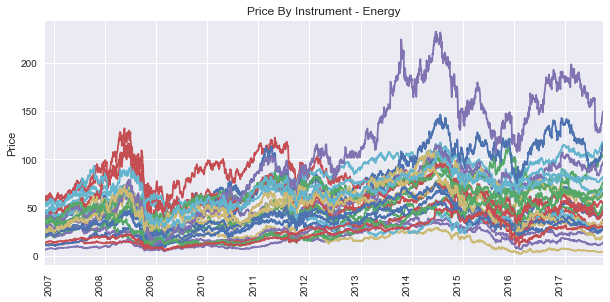

In [1054]:
# define title
titleName='Price By Instrument - '+gicsSectorName
# plot prices
prices[energyTickers].plot(legend=False,figsize=(10,5),
    rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Price")

Once again, we can examine price indices normalized for differing cross-sectional variability:

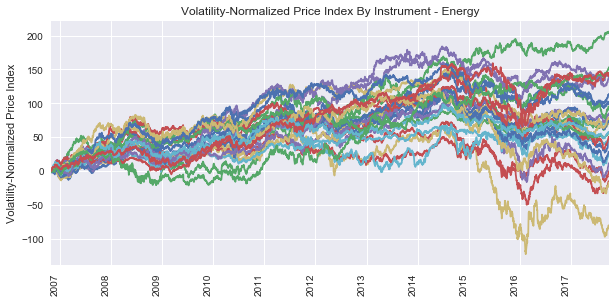

In [1055]:
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSectorName
# extract standardized returns for energy stocks
energyStdLogReturnsWithMean=stdLogReturnsWithMean[energyTickers]
# create variability-normalized price index
energyStandardizedLogPricesWithMean=energyStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
energyStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

Create indices and corresponding ticker lists for each energy sub-industry:

In [903]:
# create 'Integrated Oil & Gas' index
integratedOilAndGasIndex=instrumentMaster['gicsSubIndustryName']=='Integrated Oil & Gas'
# create 'Oil & Gas Drilling' index
oilAndGasDrillingIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Drilling'
# create 'Oil & Gas Equipment & Services' index
oilAndGasEquipmentAndServicesIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Equipment & Services'
# create 'Oil & Gas Exploration & Production' index
oilAndGasExplorationAndProductionIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Exploration & Production'
# create 'Oil & Gas Refining & Marketing' index
oilAndGasRefiningAndMarketingIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Refining & Marketing'
# create 'Oil & Gas Exploration & Production' index
oilAndGasStorageAndTransportationIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Storage & Transportation'

# extract 'Integrated Oil & Gas' stock tickers
integratedOilAndGasTickers=instrumentMaster['instrumentTicker'].loc[integratedOilAndGasIndex].values
# extract 'Oil & Gas Drilling' stock tickers
oilAndGasDrillingTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasDrillingIndex].values
# extract 'Oil & Gas Equipment & Services' stock tickers
oilAndGasEquipmentAndServicesTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasEquipmentAndServicesIndex].values
# extract 'Oil & Gas Exploration & Production' stock tickers
oilAndGasExplorationAndProductionTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasExplorationAndProductionIndex].values
# extract 'Oil & Gas Refining & Marketing' stock tickers
oilAndGasRefiningAndMarketingTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasRefiningAndMarketingIndex].values
# extract 'Oil & Gas Storage & Transportation' stock tickers
oilAndGasStorageAndTransportationTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasStorageAndTransportationIndex].values

We plot the 'Integrated Oil & Gas' variability-normalized stock price indices:

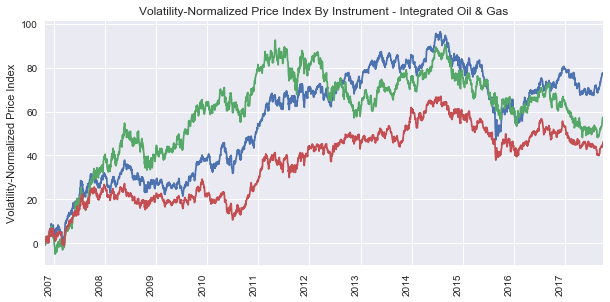

In [952]:
# set sub-industry name
gicsSubIndustryName='Integrated Oil & Gas'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
integratedOilAndGasStdLogReturnsWithMean=stdLogReturnsWithMean[integratedOilAndGasTickers]
# create variability-normalized price index
integratedOilAndGasStandardizedLogPricesWithMean=integratedOilAndGasStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
integratedOilAndGasStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

We plot the 'Oil & Gas Drilling' variability-normalized stock price indices:

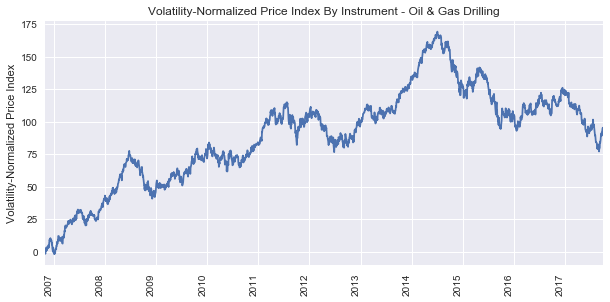

In [953]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Drilling'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasDrillingStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasDrillingTickers]
# create variability-normalized price index
oilAndGasDrillingStandardizedLogPricesWithMean=oilAndGasDrillingStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasDrillingStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

We plot the 'Oil & Gas Equipment & Services' variability-normalized stock price indices:

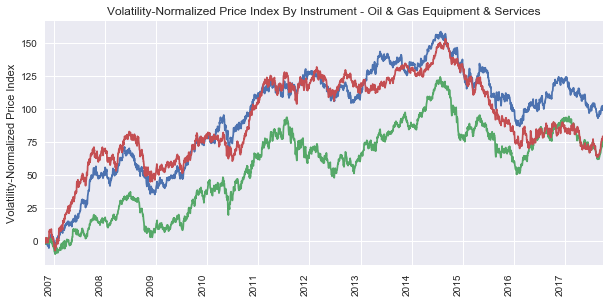

In [955]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Equipment & Services'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasEquipmentAndServicesStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasEquipmentAndServicesTickers]
# create variability-normalized price index
oilAndGasEquipmentAndServicesStandardizedLogPricesWithMean=oilAndGasEquipmentAndServicesStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasEquipmentAndServicesStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

We plot the 'Oil & Gas Exploration & Production' variability-normalized stock price indices:

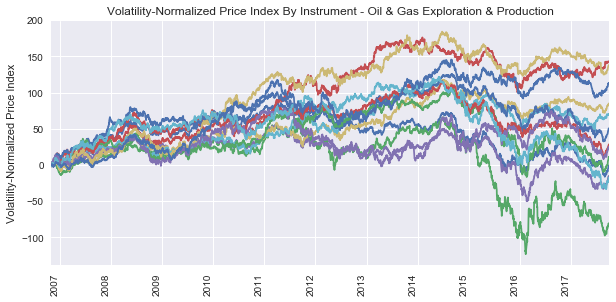

In [956]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Exploration & Production'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasExplorationAndProductionStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasExplorationAndProductionTickers]
# create variability-normalized price index
oilAndGasExplorationAndProductionStandardizedLogPricesWithMean=oilAndGasExplorationAndProductionStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasExplorationAndProductionStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

In [1057]:
# create correlation graph
energy_G=networkx.Graph()
# number of periods
nPeriods=len(energyCorrelations)
# extract the correlation matrix for the last date ('2017-09-15 00:00:00')
energy_C=energyCorrelations.loc[('2017-09-15 00:00:00', energyTickers)]
# extract the correlation matrix to a numpy array
rho=energy_C.values
# number of sector instruments
nEnergyInstruments=len(energyTickers)
# iterate over each instrument
for i in range(0,nEnergyInstruments):
    # define ticker [i]
    iTicker=energyTickers[i]
    # iterate over each instrument
    for j in range(0,nEnergyInstruments):
        # define ticker [j]
        jTicker=energyTickers[j]
        # compute distance
        metricDistance=math.sqrt(2.0*(1.0-round(rho[i,j],10)))
        # build network
        energy_G.add_edge(iTicker,jTicker,weight=metricDistance)
        
# set color attributes for network nodes
for n in energy_G.nodes():
    energy_G.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]

IndexError: index 23 is out of bounds for axis 0 with size 23

We plot the 'Oil & Gas Refining & Marketing' variability-normalized stock price indices:

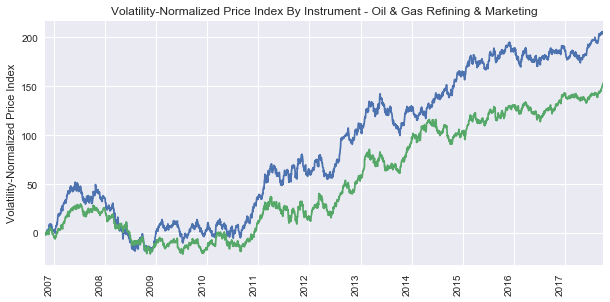

In [976]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Refining & Marketing'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasRefiningAndMarketingStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasRefiningAndMarketingTickers]
# create variability-normalized price index
oilAndGasRefiningAndMarketingStandardizedLogPricesWithMean=oilAndGasRefiningAndMarketingStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasRefiningAndMarketingStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

We plot the 'Oil & Gas Storage & Transportation' variability-normalized stock price index:

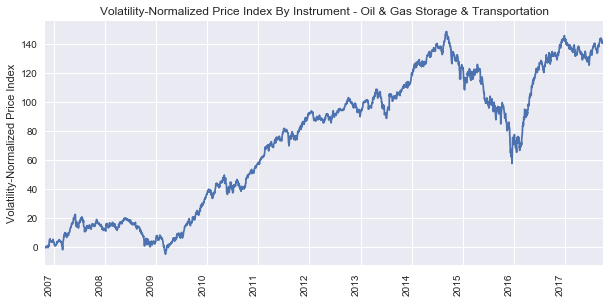

In [958]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Storage & Transportation'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasStorageAndTransportationStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasStorageAndTransportationTickers]
# create variability-normalized price index
oilAndGasStorageAndTransportationStandardizedLogPricesWithMean=oilAndGasStorageAndTransportationStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasStorageAndTransportationStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

Extract standardized returns for energy stocks:

In [959]:
# extract standardized returns for energy stocks
energyStdLogReturns=stdLogReturns[energyTickers]

Compute rolling log return correlations using a roughly 1-year lookback:

In [960]:
# define the size of the rolling window in days
lookback=250
# compute the rolling correlations
energyCorrelations=energyStdLogReturns.rolling(window=lookback,
    min_periods=lookback).corr(pairwise=True)

Plot the correlations between Andeavor and Valero Energy Corp (i.e., tickers 'ANDV' and 'VLO'):

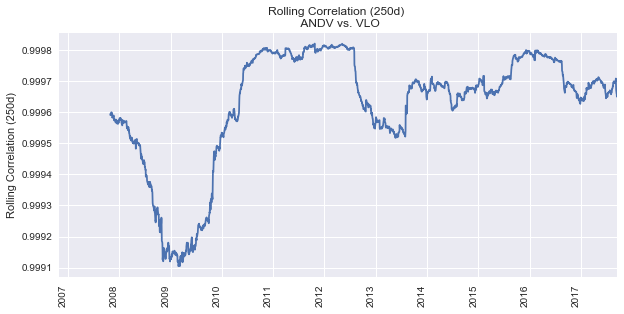

In [962]:
# define title
titleName='Rolling Correlation (250d) \n ANDV vs. VLO'
# plot rolling correlations between ANDV and VLO
energyCorrelations.unstack(1)[('ANDV', 'VLO')].plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Rolling Correlation (250d)")

##  Correlation Networks

Using the correlation values previously computed we obtain a set of $n \times (n-1)/2$ numbers characterizing the similarity of any of the $n$ stocks with respect to all the other $n-1$ stocks. This set of numbers forms a complete graph with different edge strengths given by the correlation value. To every entry of the above-computed correlation matrix we can associate a metric distance between any pair of stocks by defining

$$d_{i,j}(\Delta t)=\sqrt{2(1-\rho_{i,j}(\Delta t))}$$

$d_{i,j}(\Delta t)$ fulfils the following three axioms of a metric distance:

1) $d_{i,j}(\Delta t)=0$ if and only if $i=j$;

2) $d_{i,j}(\Delta t)=d_{i,j}(\Delta t) \forall i,j$;

3) $d_{i,j}(\Delta t) \le d_{i,k}(\Delta t) + d_{k,j}(\Delta t) \forall i,j,k$

This distance matrix $D(\Delta t)$ will be used in a later section to determine the Minimum Spanning Tree (MST) connecting the $n$ stocks in the instrument universe under study.

This distance metric is used to create our graph below.

In [926]:
# determine number of nodes
energy_nNodes=energy_G.number_of_nodes()
# display number of nodes
energy_nNodes

23

In [927]:
# determine number of edges
energy_nEdges=energy_G.number_of_edges()
# display number of edges
energy_nEdges

276

Our small network has just 29 nodes and 435 edges.

We create the visualization of the correlation network graph using the distance metric defined above as follows:

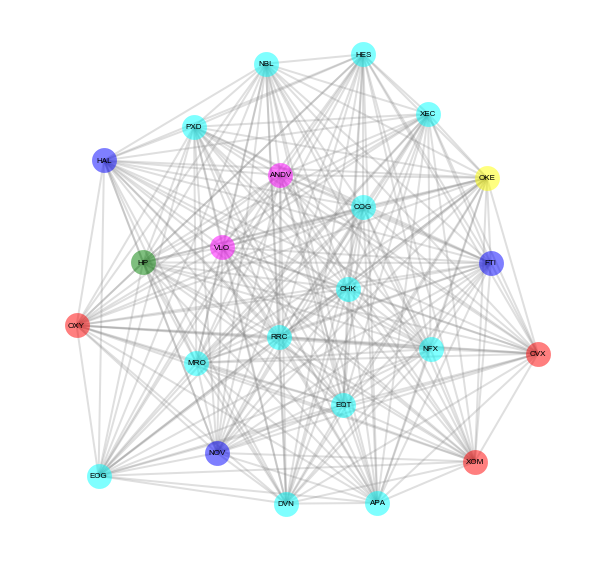

In [1022]:
plt.figure(figsize=(10,10))

# determine the positions using spring layout
energy_position=networkx.spring_layout(energy_G)

# add nodes
for n in energy_G.nodes():
    networkx.draw_networkx_nodes(energy_G, energy_position, 
    [n], node_size = 600,node_color=energy_G.node[n]['color'],
    with_labels=True,alpha=0.5)

# add edges
networkx.draw_networkx_edges(energy_G,pos=energy_position,edge_color='grey',
    alpha=0.25,width=2)

# add labels
networkx.draw_networkx_labels(energy_G,pos=energy_position,font_size=8)
# remove axis
plt.axis('off')
# display the graph
plt.show()

Color in the above network graph indicates sub-industry.

Prior to any filtering of the correlation network, our visualization does not reveal much about the structure of the network under study.

In the next section, we will look at a number of metrics before and after applying Prim's algorithm to transform our correlation network to its corresponding minimal spanning tree equivalent.

Compute the weighted degree:

In [978]:
# compute weighted degree
energy_degreeByInstrument=networkx.degree(energy_G,weight='weight')
# display
energy_degreeByInstrument

{'ANDV': 1.1670908279000693,
 'APA': 0.9852783721652324,
 'CHK': 1.3469835214896502,
 'COG': 1.2587524431431907,
 'CVX': 0.8926330536084658,
 'DVN': 0.999333567779151,
 'EOG': 0.8411791063316275,
 'EQT': 1.143277277707667,
 'FTI': 0.9935601214682417,
 'HAL': 0.8994398578887669,
 'HES': 1.0024190436566158,
 'HP': 1.051438794034533,
 'MRO': 1.1773530139183521,
 'NBL': 1.0078420751072201,
 'NFX': 1.083537576803751,
 'NOV': 1.0291154014755604,
 'OKE': 0.9735094385345613,
 'OXY': 0.9013829595474449,
 'PXD': 1.0114146602055822,
 'RRC': 1.3412432178144282,
 'VLO': 1.159676741557003,
 'XEC': 0.9379588058680663,
 'XOM': 0.8980940018492964}

Plot the weighted degree:

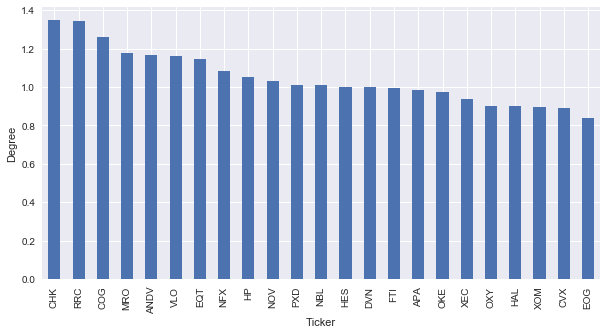

In [1023]:
plt.figure(figsize=(10,5))
energy_degreeByInstrumentDf=pandas.DataFrame(energy_degreeByInstrument,
    index=energy_degreeByInstrument.keys()).iloc[0]
energy_degreeByInstrumentDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Degree")
plt.xlabel("Ticker")

Show the top 5 instruments in terms of weighted degree:

In [980]:
# find top 5 degree by instrument
topEnergyDegreeByInstrumentDf=energy_degreeByInstrumentDf.sort_values(ascending=False).head(5)
# display top 5 degree by instrument
topEnergyDegreeByInstrumentDf

CHK     1.346984
RRC     1.341243
COG     1.258752
MRO     1.177353
ANDV    1.167091
Name: DVN, dtype: float64

In [981]:
# create index for instrument master
topEnergyDegreeByInstrumentIndex=instrumentMaster['instrumentTicker'].isin(topEnergyDegreeByInstrumentDf.index.values)
# extract instrument master for top  5 degrees
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[topEnergyDegreeByInstrumentIndex]

,Name,instrumentTicker,gicsSubIndustryName
40,Andeavor,ANDV,Oil & Gas Refining & Marketing
94,Chesapeake Energy Corp,CHK,Oil & Gas Exploration & Production
110,CABOT OIL & GAS CORP,COG,Oil & Gas Exploration & Production
324,MARATHON OIL CORP,MRO,Oil & Gas Exploration & Production
411,Range Resources Corp,RRC,Oil & Gas Exploration & Production


### Eigenvector Centrality

Eigenvector centrality is a spectral centrality measure, based on the spectral properties of the adjacency matrix, $A$.

We define the centrality of a node (vertex) $i$ as the average of the entrality of its neighbours:

$$c_{i}=\frac{1}{\lambda}\sum_{j=1,N}{a_{ij}c_{j}}$$

The above equation can be written in vectorial form as:

$$Ac=\lambda c$$

This measure of centrality is an eigenvector of the adjacency matrix, $A$, where $\lambda$ and $c$ are the corresponding eigenvalue and eigenvector respectively.

If if the graph is (strongly) connected (or equivalently, $A$ is irreducible) then the eigenvector, $c$, is both unique and positive.

To solve the above problem numerically we can use a power iteration method.

Using this measure, nodes are deemed central if they are connected to other highly central nodes.

Compute the eigenvector centrality as follows:

In [982]:
# compute weighted eigenvector centrality
energy_eigenvectorCentrality = networkx.eigenvector_centrality(energy_G,weight='weight')
# display
energy_eigenvectorCentrality

{'ANDV': 0.22893157721493992,
 'APA': 0.19584720915344866,
 'CHK': 0.2599000687508736,
 'COG': 0.24391480718218655,
 'CVX': 0.17906813363957413,
 'DVN': 0.19832410928046693,
 'EOG': 0.16935593142979977,
 'EQT': 0.22294549519198997,
 'FTI': 0.19757495291223778,
 'HAL': 0.18049596649122965,
 'HES': 0.19920926435513678,
 'HP': 0.20840098373387272,
 'MRO': 0.23153259608481996,
 'NBL': 0.20057963130280937,
 'NFX': 0.21342905373415283,
 'NOV': 0.2040965599327023,
 'OKE': 0.19385595235770686,
 'OXY': 0.18083604495588762,
 'PXD': 0.20099639659406335,
 'RRC': 0.2581345001908993,
 'VLO': 0.22767909079937873,
 'XEC': 0.18724596707114194,
 'XOM': 0.18004804273220656}

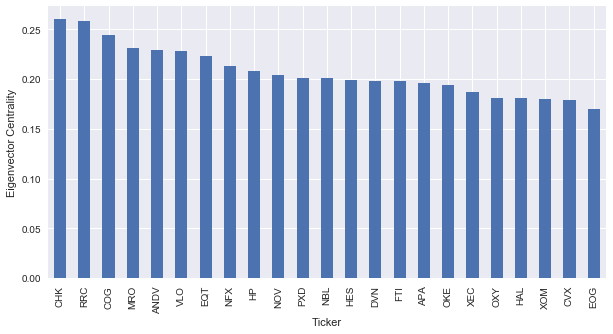

In [1024]:
plt.figure(figsize=(10,5))
energy_eigenvectorCentralityByInstrumentDf=pandas.DataFrame(energy_eigenvectorCentrality,
    index=energy_eigenvectorCentrality.keys()).iloc[0]
energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Eigenvector Centrality")
plt.xlabel("Ticker")

Show the top 5 instruments in terms of eigenvector centrality:

In [984]:
energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).head(5)

CHK     0.259900
RRC     0.258135
COG     0.243915
MRO     0.231533
ANDV    0.228932
Name: DVN, dtype: float64

Show the bottom 5 instruments in terms of eigenvector centrality:

In [985]:
energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).tail(5)

OXY    0.180836
HAL    0.180496
XOM    0.180048
CVX    0.179068
EOG    0.169356
Name: DVN, dtype: float64

In [986]:
# top 5
energy_topEigenvectorCentrality=energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).head(5).index.values
# bottom 5
energy_bottomEigenvectorCentrality=energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).tail(5).index.values

In [987]:
# create index for instrument master
topEnergyEigenvectorCentralityIndex=instrumentMaster['instrumentTicker'].isin(energy_topEigenvectorCentrality)
# extract instrument master for top  5 eigenvector centrality
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[topEnergyEigenvectorCentralityIndex]

,Name,instrumentTicker,gicsSubIndustryName
40,Andeavor,ANDV,Oil & Gas Refining & Marketing
94,Chesapeake Energy Corp,CHK,Oil & Gas Exploration & Production
110,CABOT OIL & GAS CORP,COG,Oil & Gas Exploration & Production
324,MARATHON OIL CORP,MRO,Oil & Gas Exploration & Production
411,Range Resources Corp,RRC,Oil & Gas Exploration & Production


In [988]:
# create index for instrument master
bottomEnergyEigenvectorCentralityIndex=instrumentMaster['instrumentTicker'].isin(energy_bottomEigenvectorCentrality)
# extract instrument master for top  5 eigenvector centrality
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[bottomEnergyEigenvectorCentralityIndex]

,Name,instrumentTicker,gicsSubIndustryName
127,CHEVRON CORP,CVX,Integrated Oil & Gas
165,EOG RESOURCES INC,EOG,Oil & Gas Exploration & Production
218,Halliburton Co,HAL,Oil & Gas Equipment & Services
359,OCCIDENTAL PETROLEUM CORP,OXY,Integrated Oil & Gas
509,Exxon Mobil Corp,XOM,Integrated Oil & Gas


### Minimum Spanning Tree

In the following section, we filter the energy correlation network using Prim's algorithm to create the minimal spanning tree (MST).

We create the minimal spanning tree (MST) representation of the energy stock correlation network as follows:

In [1021]:
energy_tree_seed='SWN'
energy_N_new=[]
energy_E_new=[]
energy_N_new.append(energy_tree_seed)
while len(energy_N_new) < energy_G.number_of_nodes():
    min_weight=10000000.0
    for n in energy_N_new:
        for n_adj in energy_G.neighbors(n):
            if not n_adj in energy_N_new:
                if energy_G[n][n_adj]['weight'] < min_weight:
                    min_weight=energy_G[n][n_adj]['weight']
                    min_weight_edge=(n,n_adj)
                    n_adj_ext=n_adj
    energy_E_new.append(min_weight_edge)
    energy_N_new.append(n_adj_ext)
    
# generate tree from edge list
energy_tree_graph=networkx.Graph()
energy_tree_graph.add_edges_from(energy_E_new)

# set color attributes for network nodes
for n in energy_tree_graph.nodes():
    energy_tree_graph.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]


NetworkXError: The node SWN is not in the graph.

Now we plot the minimum spanning tree (MST) as follows:

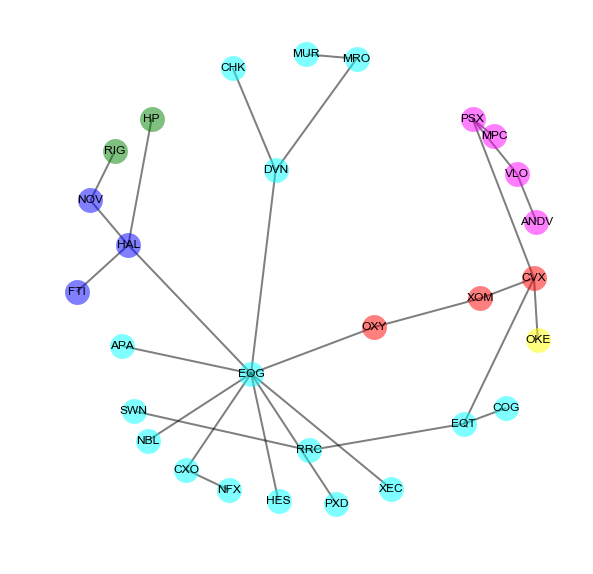

In [502]:
# create position
energy_pos=networkx.spring_layout(energy_tree_graph)
# create figure
plt.figure(figsize=(10,10))
# add edges
networkx.draw_networkx_edges(energy_tree_graph,energy_pos,width=2, 
    edge_color='black', alpha=0.5, style="solid")
# add labels
networkx.draw_networkx_labels(energy_tree_graph,energy_pos)
# add nodes
for n in energy_tree_graph.nodes():
    networkx.draw_networkx_nodes(energy_tree_graph, energy_pos, 
    [n], node_size = 600,node_color=energy_tree_graph.node[n]['color'],
    with_labels=True,alpha=0.5)
# remove axis
plt.axis('off')
# display the graph
plt.show()

The minimum spanning tree shows a large number of stocks having a single link, while other stocks have several links. Some of these stocks act as the "hub" of a local cluster. For instance, EOG Resources Inc. (EOG) appears to be central to the movement of stocks within the 'Energy' sector, particularly within the largest sub-industry, 'Oil & Gas Exploration & Production'.

In [461]:
# compute weighted degree
energy_degreeByInstrumentMST=networkx.degree(energy_tree_graph,weight='weight')
# display
energy_degreeByInstrumentMST

{'ANDV': 1,
 'APA': 1,
 'CHK': 1,
 'COG': 1,
 'CVX': 4,
 'CXO': 2,
 'DVN': 3,
 'EOG': 9,
 'EQT': 3,
 'FTI': 1,
 'HAL': 4,
 'HES': 1,
 'HP': 1,
 'MPC': 1,
 'MRO': 2,
 'MUR': 1,
 'NBL': 1,
 'NFX': 1,
 'NOV': 2,
 'OKE': 1,
 'OXY': 2,
 'PSX': 3,
 'PXD': 1,
 'RIG': 1,
 'RRC': 2,
 'SWN': 1,
 'VLO': 2,
 'XEC': 1,
 'XOM': 2}

Plot the energy sector degree by instrument based on the minimal spanning tree (MST):

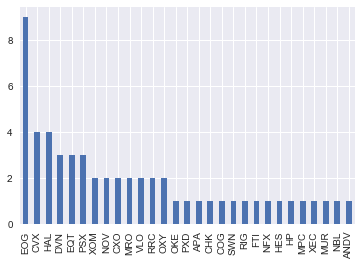

In [504]:
energy_degreeByInstrumentMSTDf=pandas.DataFrame(energy_degreeByInstrumentMST,
    index=energy_degreeByInstrumentMST.keys()).iloc[0]
energy_degreeByInstrumentMSTDf.sort_values(ascending=False).plot('bar')

Notice that we now observe a single stock - EOG Resources Inc. (EOG) - with a degree of 9. None of the stocks in the top 5 for either the weighted degree or eigenvector centrality of the unfiltered return correlation network appear significant based on the minimal spanning tree (MST) representation of the graph. In fact, the stocks with the top 5 weighted degrees of the minimal spanning tree (MST) are in the bottom of the eigenvector centrality ranking. We also observe more alignment between our sub-industry categorial variable and the identified clusters.

# Generic Sector
Add section to remove time series for which we don't have full time series

In [990]:
#gicsSectorName='Information Technology'
#gicsSectorName='Utilities'
gicsSectorName='Health Care'
# create energy stock index
gicsSectorIndex=instrumentMaster['gicsSectorName']==gicsSectorName
# extract energy stock tickers
gicsSectorTickers=instrumentMaster['instrumentTicker'].loc[gicsSectorIndex].values
# extract instrument names
sector_instrumentNames=instrumentMaster['Name'].loc[gicsSectorIndex].values
# extract GICs sub-industry names
sector_gicsSubIndustryName=instrumentMaster['gicsSubIndustryName'].loc[gicsSectorIndex].values

Create a dictionary to lookup sub-industry by ticker:

In [991]:
# create dictionary
ticker2SubIndustry=dict()
# iterate over each ticker
for i in range(0,len(gicsSectorTickers)):
    # extract ticker
    ticker=gicsSectorTickers[i]
    # extract sub-industry
    subIndustry=sector_gicsSubIndustryName[i]
    # add sub-industry by ticker
    ticker2SubIndustry[ticker]=subIndustry

In [992]:
instrumentMaster.loc[gicsSectorIndex].groupby(['Name','instrumentTicker',
    'gicsIndustryName','gicsSubIndustryName'])['gicsSectorName'].count()

# [clean up this table]


Name                                 instrumentTicker  gicsIndustryName                  gicsSubIndustryName           
AETNA INC                            AET               Health Care Providers & Services  Managed Health Care               1
ALEXION PHARMACEUTICALS INC          ALXN              Biotechnology                     Biotechnology                     1
ALIGN TECHNOLOGY INC                 ALGN              Health Care Equipment & Supplies  Health Care Supplies              1
AMGEN INC                            AMGN              Biotechnology                     Biotechnology                     1
Abbott Laboratories                  ABT               Health Care Equipment & Supplies  Health Care Equipment             1
Agilent Technologies Inc             A                 Life Sciences Tools & Services    Life Sciences Tools & Services    1
Allergan Plc                         AGN               Pharmaceuticals                   Pharmaceuticals                   1
Ameri

In [799]:
instrumentMaster.loc[gicsSectorIndex].groupby(['gicsSectorName',
    'gicsIndustryName'])['gicsIndustryName'].count()

# [clean up this table]


gicsSectorName  gicsIndustryName                
Health Care     Biotechnology                        8
                Health Care Equipment & Supplies    16
                Health Care Providers & Services    15
                Health Care Technology               1
                Life Sciences Tools & Services       6
                Pharmaceuticals                      5
Name: gicsIndustryName, dtype: int64

In [800]:
instrumentMaster.loc[gicsSectorIndex].groupby(['gicsSectorName',
    'gicsSubIndustryName'])['gicsSubIndustryName'].count()

# [clean up this table]


gicsSectorName  gicsSubIndustryName           
Health Care     Biotechnology                      8
                Health Care  Services              4
                Health Care Distributors           4
                Health Care Equipment             14
                Health Care Facilities             1
                Health Care Supplies               2
                Health Care Technology             1
                Life Sciences Tools & Services     6
                Managed Health Care                6
                Pharmaceuticals                    5
Name: gicsSubIndustryName, dtype: int64

In [801]:
unique_sector_gicsSubIndustryName=numpy.unique(sector_gicsSubIndustryName)
nGicsSubIndustry=len(unique_sector_gicsSubIndustryName)

In [966]:


#colorList=seaborn.color_palette("PuBuGn_d", nGicsSubIndustry)
colorList=seaborn.color_palette("RdBu_r", nGicsSubIndustry)

In [993]:
# define dictionary mapping sub-industry to color
subIndustry2Color=dict()
# define sub-industry n
nGicsSubIndustry=len(unique_sector_gicsSubIndustryName)
# iterate over sub-industry
for iSubIndustry in range(0,nGicsSubIndustry):
    # assign color for sub-industry
    subIndustry2Color[unique_sector_gicsSubIndustryName[iSubIndustry]]=colorList[iSubIndustry]
# display 
subIndustry2Color

{'Biotechnology': (0.11864667435601693,
  0.37923875432525955,
  0.64567474048442919),
 'Health Care  Services': (0.2366013071895425,
  0.54186851211072662,
  0.74702037677816224),
 'Health Care Distributors': (0.48143021914648199,
  0.71487889273356398,
  0.8394463667820069),
 'Health Care Equipment': (0.73241061130334484,
  0.85374855824682816,
  0.91626297577854665),
 'Health Care Facilities': (0.90142252979623216,
  0.93679354094579015,
  0.95624759707804685),
 'Health Care Supplies': (0.97923875432525953,
  0.91910803537101116,
  0.88373702422145339),
 'Health Care Technology': (0.97970011534025381,
  0.78408304498269921,
  0.68489042675893919),
 'Life Sciences Tools & Services': (0.92226066897347181,
  0.56747404844290683,
  0.4486735870818917),
 'Managed Health Care': (0.81153402537485586,
  0.32110726643598614,
  0.27581699346405225),
 'Pharmaceuticals': (0.66920415224913488,
  0.084890426758938875,
  0.16401384083044984)}

In [804]:
# display ticker to sub-industry dictionary
ticker2SubIndustry

{'A': 'Life Sciences Tools & Services',
 'ABC': 'Health Care Distributors',
 'ABT': 'Health Care Equipment',
 'AET': 'Managed Health Care',
 'AGN': 'Pharmaceuticals',
 'ALGN': 'Health Care Supplies',
 'ALXN': 'Biotechnology',
 'AMGN': 'Biotechnology',
 'ANTM': 'Managed Health Care',
 'BAX': 'Health Care Equipment',
 'BDX': 'Health Care Equipment',
 'BIIB': 'Biotechnology',
 'BMY': 'Pharmaceuticals',
 'BSX': 'Health Care Equipment',
 'CAH': 'Health Care Distributors',
 'CELG': 'Biotechnology',
 'CERN': 'Health Care Technology',
 'CI': 'Managed Health Care',
 'CNC': 'Managed Health Care',
 'DGX': 'Health Care  Services',
 'DHR': 'Health Care Equipment',
 'DVA': 'Health Care  Services',
 'ESRX': 'Health Care  Services',
 'EW': 'Health Care Equipment',
 'GILD': 'Biotechnology',
 'HOLX': 'Health Care Equipment',
 'HSIC': 'Health Care Distributors',
 'HUM': 'Managed Health Care',
 'IDXX': 'Health Care Equipment',
 'ILMN': 'Life Sciences Tools & Services',
 'INCY': 'Biotechnology',
 'ISRG': '

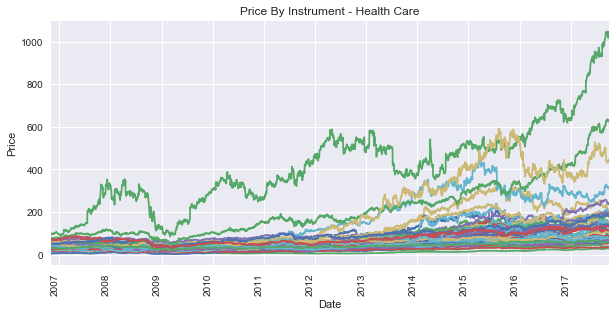

In [994]:
# define title
titleName='Price By Instrument - '+gicsSectorName
# plot price
prices[gicsSectorTickers].plot(legend=False,figsize=(10,5),
    rot=90,title=titleName)
# set y-label
plt.ylabel("Price")

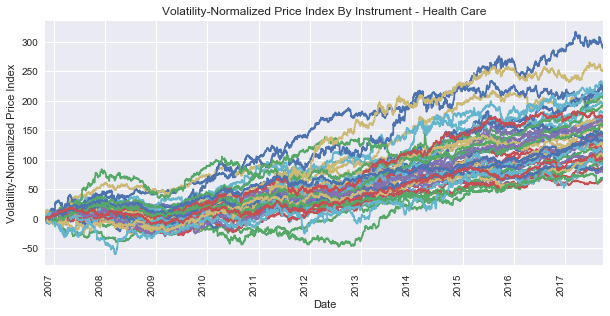

In [995]:
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSectorName
# extract standardized returns for energy stocks
gicsSectorStdLogReturnsWithMean=stdLogReturnsWithMean[gicsSectorTickers]
# create variability-normalized price index
gicsSectorStandardizedLogPricesWithMean=gicsSectorStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
gicsSectorStandardizedLogPricesWithMean.plot(legend=False,figsize=(10,5),
    rot=90,title=titleName)
# set y-label
plt.ylabel("Volatility-Normalized Price Index")

In [996]:
# extract standardized returns for energy stocks
gicsSectorStdLogReturns=stdLogReturns[gicsSectorTickers]

In [997]:
# define the size of the rolling window in days
lookback=250
# compute the rolling correlations
gicsSectorCorrelations=gicsSectorStdLogReturns.rolling(window=lookback,
    min_periods=lookback).corr(pairwise=True)

##  Correlation Networks

Using the correlation values previously computed we obtain a set of $n \times (n-1)/2$ numbers characterizing the similarity of any of the $n$ stocks with respect to all the other $n-1$ stocks. This set of numbers forms a complete graph with different edge strengths given by the correlation value. To every entry of the above-computed correlation matrix we can associate a metric distance between any pair of stocks by defining

$$d_{i,j}(\Delta t)=\sqrt{2(1-\rho_{i,j}(\Delta t))}$$

$d_{i,j}(\Delta t)$ fulfils the following three axioms of a metric distance:

1) $d_{i,j}(\Delta t)=0$ if and only if $i=j$;

2) $d_{i,j}(\Delta t)=d_{i,j}(\Delta t) \forall i,j$;

3) $d_{i,j}(\Delta t) \le d_{i,k}(\Delta t) + d_{k,j}(\Delta t) \forall i,j,k$

This distance matrix $D(\Delta t)$ will be used in a later section to determine the Minimum Spanning Tree (MST) connecting the $n$ stocks in the instrument universe under study.

This distance metric is used to create our graph below.

We create the visualization of the correlation network graph using the distance metric defined above as follows:

In [998]:
#
nGicsSectorInstruments=len(gicsSectorTickers)
# create correlation graph
gicsSector_G=networkx.Graph()
import math
# number of periods
nPeriods=len(gicsSectorCorrelations)
# extract the correlation matrix for the last date ('2017-09-15 00:00:00')
gicsSector_C=gicsSectorCorrelations.loc[('2017-09-15 00:00:00', gicsSectorTickers)]
# extract the correlation matrix to a numpy array
rho=gicsSector_C.values
# iterate over each instrument
for i in range(0,nGicsSectorInstruments):
    # define ticker [i]
    iTicker=gicsSectorTickers[i]
    # iterate over each instrument
    for j in range(0,nGicsSectorInstruments):
        # define ticker [j]
        jTicker=gicsSectorTickers[j]
        # compute distance
        metricDistance=math.sqrt(2.0*(1.0-round(rho[i,j],10)))
        # build network
        gicsSector_G.add_edge(iTicker,jTicker,weight=metricDistance)
        
# set color attributes for network nodes
for n in gicsSector_G.nodes():
    gicsSector_G.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]

In [999]:
# determine number of nodes
gicsSector_nNodes=gicsSector_G.number_of_nodes()
# display number of nodes
gicsSector_nNodes

51

In [1000]:
# determine number of edges
gicsSector_nEdges=gicsSector_G.number_of_edges()
# display number of edges
gicsSector_nEdges

1326

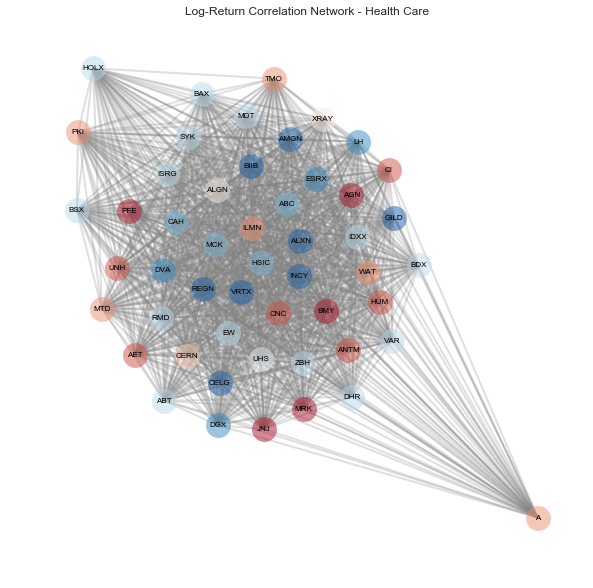

In [1001]:
# define title
titleName='Log-Return Correlation Network - '+gicsSectorName
# set figure size
plt.figure(figsize=(10,10))
# add title
plt.title(titleName)
# determine the positions using spring layout
gicsSector_position=networkx.spring_layout(gicsSector_G)

# add nodes
for n in gicsSector_G.nodes():
    networkx.draw_networkx_nodes(gicsSector_G, gicsSector_position, 
    [n], node_size = 600,node_color=gicsSector_G.node[n]['color'],
    with_labels=True,alpha=0.5)

# add edges
networkx.draw_networkx_edges(gicsSector_G,pos=gicsSector_position,
    edge_color='grey',alpha=0.25,width=2)

# add labels
networkx.draw_networkx_labels(gicsSector_G,pos=gicsSector_position,
    font_size=8)
# remove axis
plt.axis('off')
# display the graph
plt.show()

Color in the above network graph indicates sub-industry.

Prior to any filtering of the correlation network, our visualization does not reveal much about the structure of the network under study.

In the next section, we will look at a number of metrics before and after applying Prim's algorithm to transform our correlation network to its corresponding minimal spanning tree equivalent.

In [1002]:
# compute weighted degree
gicsSector_degreeByInstrument=networkx.degree(gicsSector_G,
    weight='weight')
# display
gicsSector_degreeByInstrument

{'A': 1.9506208208666571,
 'ABC': 2.710048349519248,
 'ABT': 1.8723919145179977,
 'AET': 1.9790990704252347,
 'AGN': 2.203884048650905,
 'ALGN': 2.468893924861263,
 'ALXN': 3.2924235789331386,
 'AMGN': 2.127609424412133,
 'ANTM': 2.1116222850089064,
 'BAX': 1.9267831523137073,
 'BDX': 1.933827973018199,
 'BIIB': 2.34906342763244,
 'BMY': 2.496033279928881,
 'BSX': 1.9644551743808565,
 'CAH': 2.35746908513873,
 'CELG': 2.1984843908477707,
 'CERN': 2.2543078862605617,
 'CI': 2.034577175086987,
 'CNC': 3.04974703595923,
 'DGX': 1.8800093728598248,
 'DHR': 1.840398155411933,
 'DVA': 2.3486222374575125,
 'ESRX': 2.39090460441679,
 'EW': 2.700168281342079,
 'GILD': 2.1967946277030603,
 'HOLX': 2.145402248091348,
 'HSIC': 5.398688972954587,
 'HUM': 2.1634635789080945,
 'IDXX': 2.3081758154633865,
 'ILMN': 3.370939665385172,
 'INCY': 3.285400311136003,
 'ISRG': 2.0928594565905536,
 'JNJ': 1.8344559940942302,
 'LH': 2.0437001071472265,
 'MCK': 2.99894508502433,
 'MDT': 1.9719891905197309,
 'MRK

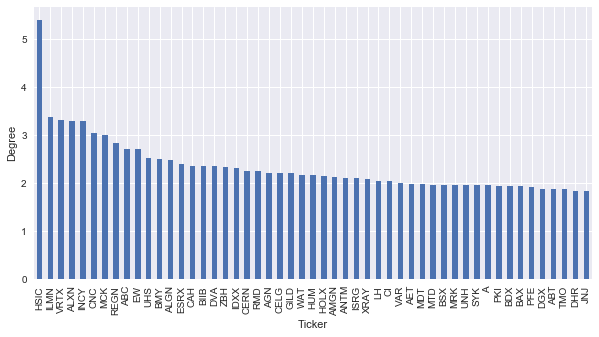

In [1003]:
plt.figure(figsize=(10,5))
gicsSector_degreeByInstrumentDf=pandas.DataFrame(gicsSector_degreeByInstrument,
    index=gicsSector_degreeByInstrument.keys()).iloc[0]
gicsSector_degreeByInstrumentDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Degree")
plt.xlabel("Ticker")

In [1004]:
# find top 5 degree by instrument
topGicsSectorDegreeByInstrumentDf=gicsSector_degreeByInstrumentDf.sort_values(ascending=False).head(5)
# display top 5 degree by instrument
topGicsSectorDegreeByInstrumentDf

HSIC    5.398689
ILMN    3.370940
VRTX    3.301796
ALXN    3.292424
INCY    3.285400
Name: AGN, dtype: float64

In [1005]:
# bottom 5
gicsSector_bottomDegreeByInstrumentDf=gicsSector_degreeByInstrumentDf.sort_values(ascending=False).tail(5)
# display bottom 5 degree by instrument
gicsSector_bottomDegreeByInstrumentDf

DGX    1.880009
ABT    1.872392
TMO    1.869975
DHR    1.840398
JNJ    1.834456
Name: AGN, dtype: float64

In [1006]:
# create index for instrument master
topGicsSectorDegreeByInstrumentIndex=instrumentMaster['instrumentTicker'].isin(topGicsSectorDegreeByInstrumentDf.index.values)
# extract instrument master for top  5 degrees
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[topGicsSectorDegreeByInstrumentIndex]

,Name,instrumentTicker,gicsSubIndustryName
30,ALEXION PHARMACEUTICALS INC,ALXN,Biotechnology
238,HENRY SCHEIN INC,HSIC,Health Care Distributors
246,ILLUMINA INC,ILMN,Life Sciences Tools & Services
247,Incyte Corp,INCY,Biotechnology
486,VERTEX PHARMACEUTICALS INC,VRTX,Biotechnology


In [1007]:
# create index for instrument master
bottomGicsSectorDegreeByInstrumentIndex=instrumentMaster['instrumentTicker'].isin(gicsSector_bottomDegreeByInstrumentDf.index.values)
# extract instrument master for top  5 eigenvector centrality
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[bottomGicsSectorDegreeByInstrumentIndex]

,Name,instrumentTicker,gicsSubIndustryName
6,Abbott Laboratories,ABT,Health Care Equipment
135,Quest Diagnostics Inc,DGX,Health Care Services
137,DANAHER CORP,DHR,Health Care Equipment
262,Johnson & Johnson,JNJ,Pharmaceuticals
454,THERMO FISHER SCIENTIFIC INC,TMO,Life Sciences Tools & Services


### Eigenvector Centrality

Eigenvector centrality is a spectral centrality measure, based on the spectral properties of the adjacency matrix, $A$.

We define the centrality of a node (vertex) $i$ as the average of the entrality of its neighbours:

$$c_{i}=\frac{1}{\lambda}\sum_{j=1,N}{a_{ij}c_{j}}$$

The above equation can be written in vectorial form as:

$$Ac=\lambda c$$

This measure of centrality is an eigenvector of the adjacency matrix, $A$, where $\lambda$ and $c$ are the corresponding eigenvalue and eigenvector respectively.

If if the graph is (strongly) connected (or equivalently, $A$ is irreducible) then the eigenvector, $c$, is both unique and positive.

To solve the above problem numerically we can use a power iteration method.

Using this measure, nodes are deemed central if they are connected to other highly central nodes.

In [820]:
# compute weighted eigenvector centrality
gicsSector_eigenvectorCentrality = networkx.eigenvector_centrality(gicsSector_G,weight='weight')
# display
gicsSector_eigenvectorCentrality

{'A': 0.11681037356846902,
 'ABC': 0.15534024381542086,
 'ABT': 0.11253024101078628,
 'AET': 0.11792608392208076,
 'AGN': 0.12902296341089947,
 'ALGN': 0.1434424266348237,
 'ALXN': 0.18587848453491515,
 'AMGN': 0.12512462902028282,
 'ANTM': 0.12494133576131763,
 'BAX': 0.11546894772686533,
 'BDX': 0.11591832213639265,
 'BIIB': 0.1366304899085791,
 'BMY': 0.14460715897272497,
 'BSX': 0.11744254211073983,
 'CAH': 0.13712750781736757,
 'CELG': 0.12864512199997555,
 'CERN': 0.13248933828565734,
 'CI': 0.12074300255328278,
 'CNC': 0.1742205861603056,
 'DGX': 0.11291936325965812,
 'DHR': 0.11090251469257281,
 'DVA': 0.13747073161553194,
 'ESRX': 0.1391731509967632,
 'EW': 0.15608796209948714,
 'GILD': 0.12891698984806493,
 'HOLX': 0.12681662568175187,
 'HSIC': 0.29302658106663254,
 'HUM': 0.12757562616238713,
 'IDXX': 0.1353617011240066,
 'ILMN': 0.19016145769318726,
 'INCY': 0.18507446372157724,
 'ISRG': 0.12405406208075745,
 'JNJ': 0.11066623532283619,
 'LH': 0.12142260234525591,
 'MCK': 0

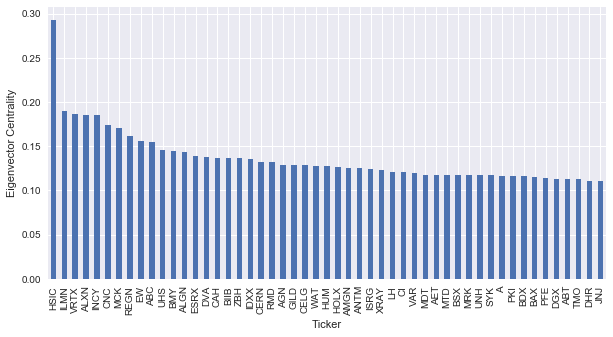

In [1008]:
plt.figure(figsize=(10,5))
gicsSector_eigenvectorCentralityByInstrumentDf=pandas.DataFrame(gicsSector_eigenvectorCentrality,
    index=gicsSector_eigenvectorCentrality.keys()).iloc[0]
gicsSector_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Eigenvector Centrality")
plt.xlabel("Ticker")


In [1009]:
# top 5
gicsSector_topEigenvectorCentrality=gicsSector_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).head(5).index.values
# bottom 5
gicsSector_bottomEigenvectorCentrality=gicsSector_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).tail(5).index.values

In [1010]:
# create index for instrument master
topGicsSectorEigenvectorCentralityIndex=instrumentMaster['instrumentTicker'].isin(gicsSector_topEigenvectorCentrality)
# extract instrument master for top  5 eigenvector centrality
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[topGicsSectorEigenvectorCentralityIndex]

,Name,instrumentTicker,gicsSubIndustryName
30,ALEXION PHARMACEUTICALS INC,ALXN,Biotechnology
238,HENRY SCHEIN INC,HSIC,Health Care Distributors
246,ILLUMINA INC,ILMN,Life Sciences Tools & Services
247,Incyte Corp,INCY,Biotechnology
486,VERTEX PHARMACEUTICALS INC,VRTX,Biotechnology


Show the bottom 5 instruments in terms of eigenvector centrality:

In [1011]:
# create index for instrument master
bottomGicsSectorEigenvectorCentralityIndex=instrumentMaster['instrumentTicker'].isin(gicsSector_bottomEigenvectorCentrality)
# extract instrument master for top  5 eigenvector centrality
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[bottomGicsSectorEigenvectorCentralityIndex]

,Name,instrumentTicker,gicsSubIndustryName
6,Abbott Laboratories,ABT,Health Care Equipment
135,Quest Diagnostics Inc,DGX,Health Care Services
137,DANAHER CORP,DHR,Health Care Equipment
262,Johnson & Johnson,JNJ,Pharmaceuticals
454,THERMO FISHER SCIENTIFIC INC,TMO,Life Sciences Tools & Services


In [1012]:
gicsSector_tree_seed=gicsSectorTickers[0]
gicsSector_N_new=[]
gicsSector_E_new=[]
gicsSector_N_new.append(gicsSector_tree_seed)
while len(gicsSector_N_new) < gicsSector_G.number_of_nodes():
    min_weight=10000000.0
    for n in gicsSector_N_new:
        for n_adj in gicsSector_G.neighbors(n):
            if not n_adj in gicsSector_N_new:
                if gicsSector_G[n][n_adj]['weight'] < min_weight:
                    min_weight=gicsSector_G[n][n_adj]['weight']
                    min_weight_edge=(n,n_adj)
                    n_adj_ext=n_adj
    gicsSector_E_new.append(min_weight_edge)
    gicsSector_N_new.append(n_adj_ext)
    
# generate tree from edge list
gicsSector_tree_graph=networkx.Graph()
gicsSector_tree_graph.add_edges_from(gicsSector_E_new)

# set color attributes for network nodes
for n in gicsSector_tree_graph.nodes():
    gicsSector_tree_graph.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]

Now we plot the minimum spanning tree (MST) as follows:

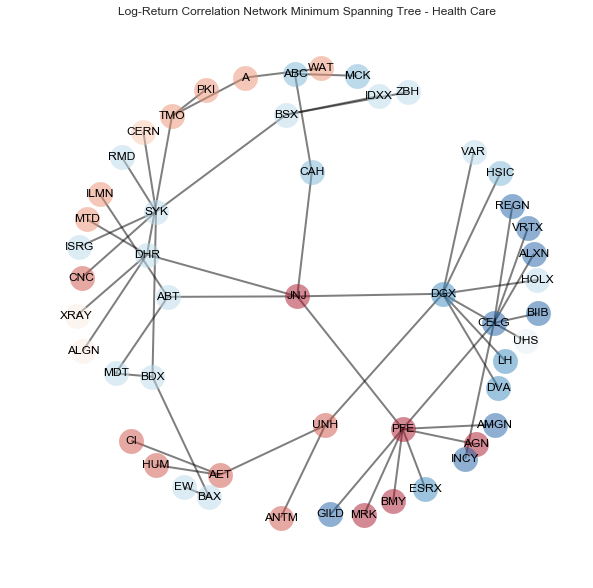

In [1014]:
# create position
gicsSector_pos=networkx.spring_layout(gicsSector_tree_graph)
# define title
titleName='Log-Return Correlation Network Minimum Spanning Tree - '+gicsSectorName
# set figure size
plt.figure(figsize=(10,10))
# add title
plt.title(titleName)
# add edges
networkx.draw_networkx_edges(gicsSector_tree_graph,gicsSector_pos,width=2, 
    edge_color='black', alpha=0.5, style="solid")
# add labels
networkx.draw_networkx_labels(gicsSector_tree_graph,gicsSector_pos)
# add nodes
for n in gicsSector_tree_graph.nodes():
    networkx.draw_networkx_nodes(gicsSector_tree_graph, gicsSector_pos, 
    [n], node_size = 600,node_color=gicsSector_tree_graph.node[n]['color'],
    with_labels=True,alpha=0.5)
# remove axis
plt.axis('off')
# display the graph
plt.show()

In [1016]:
# compute weighted degree
gicsSector_degreeByInstrumentMST=networkx.degree(gicsSector_tree_graph,
    weight='weight')

In [1017]:
# convert degree dictionary to dataframe
gicsSector_degreeByInstrumentMstDf=pandas.DataFrame.from_dict(gicsSector_degreeByInstrumentMST,
    orient='index')
# rename column
gicsSector_degreeByInstrumentMstDf.rename(columns={0 : 'degree'},inplace=True)
# join degree and instrument master (by ticker)
degreeByInstrumentMstTable=pandas.merge(gicsSector_degreeByInstrumentMstDf, 
    instrumentMaster, how='inner', left_index=True, right_on='instrumentTicker')
# display result
degreeByInstrumentMstTable

,degree,instrumentTicker,csiNumber,maxDate,minDate,CSI,Symbol,Exchange,Name,Price Format,...,sectorCodeCsi,sectorNameCsi,industryCodeCsi,industryNameCsi,securityTypeCodeCsi,securityTypeNameCsi,gicsSectorName,gicsIndustryGroupName,gicsIndustryName,gicsSubIndustryName
19,1,AGN,2087,2017-09-15,1993-02-17,2087,AGN,NYSE,Allergan Plc,2,...,HC,Healthcare,DG,Drugs - Generic,ORD,Common Stock,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals
17,3,AET,5030,2017-09-15,1985-08-01,5030,AET,NYSE,AETNA INC,2,...,HC,Healthcare,HC,Health Care Plans,ORD,Common Stock,Health Care,Health Care Equipment & Services,Health Care Providers & Services,Managed Health Care
153,1,DVA,11234,2017-09-15,1995-10-31,11234,DVA,NYSE,DaVita Inc,2,...,HC,Healthcare,SH,Specialized Health Services,ORD,Common Stock,Health Care,Health Care Equipment & Services,Health Care Providers & Services,Health Care Services
35,1,AMGN,5984,2017-09-15,1985-08-01,5984,AMGN,NASDAQ(GS),AMGEN INC,2,...,HC,Healthcare,BT,Biotechnology,ORD,Common Stock,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology
61,2,BAX,5186,2017-09-15,1985-08-01,5186,BAX,NYSE,BAXTER INTERNATIONAL INC,2,...,HC,Healthcare,MI,Medical Instruments & Supplies,ORD,Common Stock,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
400,1,REGN,8018,2017-09-15,1991-04-02,8018,REGN,NASDAQ(GS),REGENERON PHARMACEUTICALS INC,2,...,HC,Healthcare,BT,Biotechnology,ORD,Common Stock,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology
470,3,UNH,9825,2017-09-15,1985-08-01,9825,UNH,NYSE,UNITEDHEALTH GROUP INC,2,...,HC,Healthcare,HC,Health Care Plans,ORD,Common Stock,Health Care,Health Care Equipment & Services,Health Care Providers & Services,Managed Health Care
244,1,IDXX,8940,2017-09-15,1991-06-21,8940,IDXX,NASDAQ(GS),IDEXX LABORATORIES INC,2,...,HC,Healthcare,DS,Diagnostic Substances,ORD,Common Stock,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
454,3,TMO,5872,2017-09-15,1985-08-01,5872,TMO,NYSE,THERMO FISHER SCIENTIFIC INC,2,...,HC,Healthcare,ML,Medical Laboratories & Research,ORD,Common Stock,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,Life Sciences Tools & Services
75,3,BSX,4943,2017-09-15,1992-05-19,4943,BSX,NYSE,Boston Scientific Corp,2,...,HC,Healthcare,MA,Medical Appliances & Equipment,ORD,Common Stock,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment


Plot the sub-industry sector degree by instrument based on the minimal spanning tree (MST):

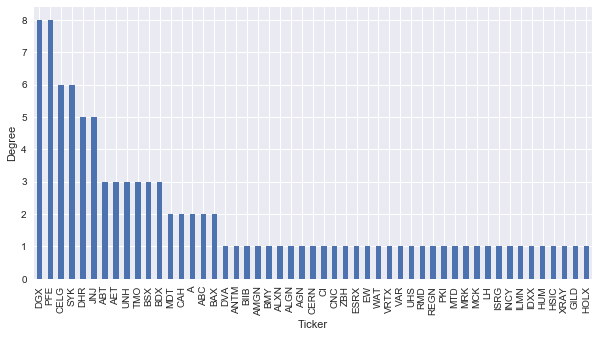

In [1018]:
plt.figure(figsize=(10,5))
gicsSector_degreeByInstrumentMSTDf=pandas.DataFrame(gicsSector_degreeByInstrumentMST,
    index=gicsSector_degreeByInstrumentMST.keys()).iloc[0]
gicsSector_degreeByInstrumentMSTDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Degree")
plt.xlabel("Ticker")

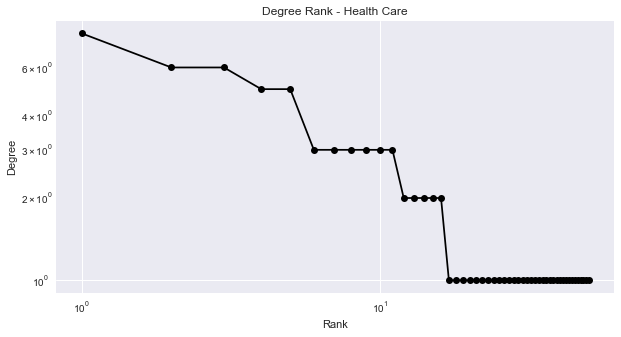

In [836]:
plt.figure(figsize=(10,5))
# create the sorted degree sequence
gicsSector_degree_sequence=sorted(gicsSector_degreeByInstrumentMST.values(),
    reverse=True) # degree sequence
# create the plot
plt.loglog(gicsSector_degree_sequence,'k-',marker='o')
plt.title("Degree Rank - "+gicsSectorName)
plt.ylabel("Degree")
plt.xlabel("Rank")
plt.show()

### Conclusion

TBD